# Stellar micro-lensing simulation

In this notebook, we simulate and animate stellar micro-lensing events.
Lentstronomy does not perform any approximations to speed up the calculation and is capable to compute micro-lensing events of arbitrary complexities

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from lenstronomy.Cosmo.micro_lensing import einstein_radius, source_size
from lenstronomy.Util import util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm import tqdm
from matplotlib.gridspec import GridSpec

## Single lens

In [2]:
# define the microlens

# =========
# distances
# =========

d_l = 4000  # distance of the lens in pc
d_s = 8000  # distance of the source in pc

# ===========
# lens system
# ===========

M0 = 0.01  # mass of the main lens in units of M_sol
# (mass is choosen relatively small such that the numerical ray-tracing is efficient)


# ===========
# source size
# ===========

diameter_s = 1  # size of the radius of the source star in units of the solar radius


In [3]:
# compute lensing properties

theta_E = einstein_radius(M0, d_l, d_s)
print(theta_E, 'Einstein radius [arc seconds]')

size_s = source_size(diameter_s, d_s)
print(size_s, 'source size [arc seconds]')


0.00010090910723578977 Einstein radius [arc seconds]
1.163118159836867e-06 source size [arc seconds]


In [4]:
# compute ray-tracing grid

grid_scale = size_s / 4.  # ten times the source size resolution
grid_width = theta_E * 4
num_pix = int(grid_width / grid_scale)
print(num_pix, "number of pixels per axis")

x, y = util.make_grid(numPix=num_pix, deltapix=grid_scale)

1388 number of pixels per axis


In [5]:
# map image to source plane
lens = LensModel(lens_model_list=['POINT_MASS'])
kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}]

beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

## source light profile
# compute surface brightness
light = LightModel(light_model_list=['ELLIPSOID'])
kwargs_light = [{'amp': 1, 'radius': size_s/2 * 10, 'e1': 0, 'e2': 0, 'center_x': 0 + theta_E/4, 'center_y': 0}]
surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)

# calculate image magnification as integral of the surface brightness 
# ('amp'=1 is normalized such that intrinsic flux=1)

mag = np.sum(surface_brightness * grid_scale**2)
print(mag, "image magnification")

# turn 1d array into 2d image
image = util.array2image(surface_brightness)

# original source light profile
org_src_img = light.surface_brightness(x, y, kwargs_light)
org_src_img = util.array2image(org_src_img)

4.095056685754468 image magnification


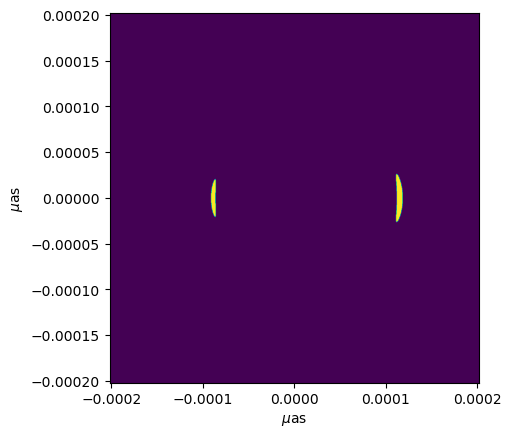

In [6]:
plt.imshow(image, extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
plt.xlabel(r'$\mu$as')
plt.ylabel(r'$\mu$as')
plt.show()

### Source Moves Behind the Lens

Einstein radius [arc seconds]: 0.00010090910723578977
source size [arc seconds]: 1.163118159836867e-06
ray-tracing grid: 1388 number of pixels per axis
image magnification: 4.095056685754468


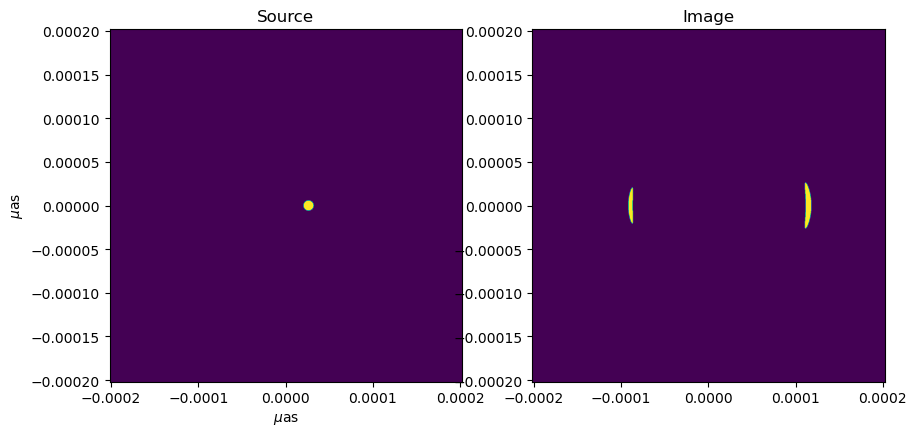

In [7]:

def plot_source_and_image_side_by_side_single_lens(d_l = 4000, 
                                       d_s = 8000, 
                                       M0 = 0.01, 
                                       diameter_s = 1,
                                       source_pos_x = 1/4,
                                       source_pos_y = 0,
                                       ax=None,
                                       print_numbers=True):
    """
    :param d_l: distance to the lens in pc. Default is 4000 pc
    :param d_s: distance to the source in pc. Default is 8000 pc
    :param M0: mass of the lens in units of M_sol. Default is 0.01 (mass is choosen relatively small such that the numerical ray-tracing is efficient)
    :param diameter_s: diameter of the source in units of the solar radius. Default is 1
    :param source_pos_x: x position of the source in units of einstein radius. Default is 1/4
    :param source_pos_y: y position of the source in units of einstein radius. Default is 0
    :param ax: matplotlib axis instance. Default is None
    """
    # compute lensing properties
    theta_E = einstein_radius(M0, d_l, d_s)
    size_s = source_size(diameter_s, d_s)

    # compute ray-tracing grid
    grid_scale = size_s / 4.  # ten times the source size resolution
    grid_width = theta_E * 4
    num_pix = int(grid_width / grid_scale)
    x, y = util.make_grid(numPix=num_pix, deltapix=grid_scale)

    ## lens model
    # map image to source plane
    lens = LensModel(lens_model_list=['POINT_MASS'])
    kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}]
    beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

    ## source light profile
    # compute surface brightness
    light = LightModel(light_model_list=['ELLIPSOID'])
    kwargs_light = [{'amp': 1, 'radius': size_s/2 * 10, 'e1': 0, 'e2': 0, 'center_x': source_pos_x*theta_E, 'center_y': source_pos_y*theta_E}]

    # turn 1d array into 2d image
    surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
    lensed_src_img = util.array2image(surface_brightness)

    # calculate image magnification as integral of the surface brightness 
    # ('amp'=1 is normalized such that intrinsic flux=1)
    mag = np.sum(surface_brightness * grid_scale**2)

    # original source light profile
    org_src_img = light.surface_brightness(x, y, kwargs_light)
    org_src_img = util.array2image(org_src_img)

    if print_numbers:
        print("Einstein radius [arc seconds]:", theta_E)
        print("source size [arc seconds]:", size_s)
        print("ray-tracing grid:", num_pix, "number of pixels per axis")
        print("image magnification:", mag)

    # plot the images side by side

    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(org_src_img, extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
    ax[0].set_title("Source")
    ax[0].set_xlabel(r'$\mu$as')
    ax[0].set_ylabel(r'$\mu$as')
    ax[1].imshow(lensed_src_img, extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
    ax[1].set_title("Image")

plot_source_and_image_side_by_side_single_lens()

In [ ]:
# interactive plot, move the sliders to change the parameters

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(plot_source_and_image_side_by_side_single_lens,
            d_l = widgets.IntSlider(min=1000, max=10000, step=1000, value=4000),
            d_s = widgets.IntSlider(min=1000, max=10000, step=1000, value=8000),
            M0 = widgets.FloatSlider(min=0.001, max=0.1, step=0.001, value=0.01),
            diameter_s = widgets.FloatSlider(min=0.1, max=10, step=0.1, value=1),
            source_pos_x = widgets.FloatSlider(min=-1, max=1, step=0.1, value=0.25),
            source_pos_y = widgets.FloatSlider(min=-1, max=1, step=0.1, value=0),
            ax=fixed(None)
            )

interactive(children=(IntSlider(value=4000, description='d_l', max=10000, min=1000, step=1000), IntSlider(valu…

<function __main__.plot_source_and_image_side_by_side_single_lens(d_l=4000, d_s=8000, M0=0.01, diameter_s=1, source_pos_x=0.25, source_pos_y=0, ax=None, print_numbers=True)>

### Animation: Source Moves Behind the Lens

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm import tqdm

def plot_source_and_image_side_by_side_single_lens_animation(d_l = 4000, 
                                       d_s = 8000, 
                                       M0 = 0.01, 
                                       diameter_s = 1,
                                       source_pos_x_vals = np.linspace(-1, 1, 100),
                                       source_pos_y = 1/4, # fixed
                                       ):
    """
    :param d_l: distance to the lens in pc. Default is 4000 pc
    :param d_s: distance to the source in pc. Default is 8000 pc
    :param M0: mass of the lens in units of M_sol. Default is 0.01 (mass is choosen relatively small such that the numerical ray-tracing is efficient)
    :param diameter_s: diameter of the source in units of the solar radius. Default is 1
    :param source_pos_x: x position of the source in units of einstein radius. Default is 1/4
    :param source_pos_y: y position of the source in units of einstein radius. Default is 0
    :param ax: matplotlib axis instance. Default is None
    """
    # compute lensing properties
    theta_E = einstein_radius(M0, d_l, d_s)
    size_s = source_size(diameter_s, d_s)

    # compute ray-tracing grid
    grid_scale = size_s / 4.  # ten times the source size resolution
    grid_width = theta_E * 4
    num_pix = int(grid_width / grid_scale)
    x, y = util.make_grid(numPix=num_pix, deltapix=grid_scale)

    ## lens model
    # map image to source plane
    lens = LensModel(lens_model_list=['POINT_MASS'])
    kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}]
    beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

    org_src_imgs = []
    lensed_src_imgs = []
    src_magnifications = []
    for source_pos_x in tqdm(source_pos_x_vals, desc="Generating images"):
        ## source light profile
        # compute surface brightness
        light = LightModel(light_model_list=['ELLIPSOID'])
        kwargs_light = [{'amp': 1, 'radius': size_s/2 * 10, 'e1': 0, 'e2': 0, 'center_x': source_pos_x*theta_E, 'center_y': source_pos_y*theta_E}]

        # turn 1d array into 2d image
        surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
        lensed_src_img = util.array2image(surface_brightness)

        # calculate image magnification as integral of the surface brightness 
        # ('amp'=1 is normalized such that intrinsic flux=1)
        mag = np.sum(surface_brightness * grid_scale**2)
        src_magnifications.append(mag)

        # original source light profile
        org_src_img = light.surface_brightness(x, y, kwargs_light)
        org_src_img = util.array2image(org_src_img)

        org_src_imgs.append(org_src_img)
        lensed_src_imgs.append(lensed_src_img)

    # plot the images side by side and make an animation
    fig = plt.figure(figsize=(19, 12))
    gs = GridSpec(2, 2, height_ratios=[1, 0.5], hspace=0.3, wspace=0.3)

    ax = [fig.add_subplot(gs[0, 0]),  # First row, first column
          fig.add_subplot(gs[0, 1]),  # First row, second column
          fig.add_subplot(gs[1, :])]  # Second row, spanning both columns

    def update(i):
        ax[0].imshow(org_src_imgs[i], extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
        ax[1].imshow(lensed_src_imgs[i], extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
        ax[2].cla()
        ax[2].plot(source_pos_x_vals[:i]*theta_E, src_magnifications[:i])
        ax[2].set_title("Source magnification")
        ax[2].set_xlabel("source position x [$\\mu$as]")
        ax[2].set_ylabel("magnification")
        ax[2].set_xlim(-grid_width/2, grid_width/2)
        ax[2].set_ylim(np.min(src_magnifications)-0.1, np.max(src_magnifications)+0.1)

    ax[0].set_title("Source")
    ax[0].set_xlabel(r'$\mu$as')
    ax[0].set_ylabel(r'$\mu$as')
    ax[1].set_title("Image")
    ax[1].set_xlabel(r'$\mu$as')
    ax[1].set_ylabel(r'$\mu$as')

    fig.suptitle(f"Source and image side by side with changing source position x at fixed y = {source_pos_y} Einstein radius", fontsize=16)

    anim  = animation.FuncAnimation(fig, update, frames=len(source_pos_x_vals), interval=100)

    return anim

Generating images: 100%|██████████| 100/100 [00:06<00:00, 14.34it/s]


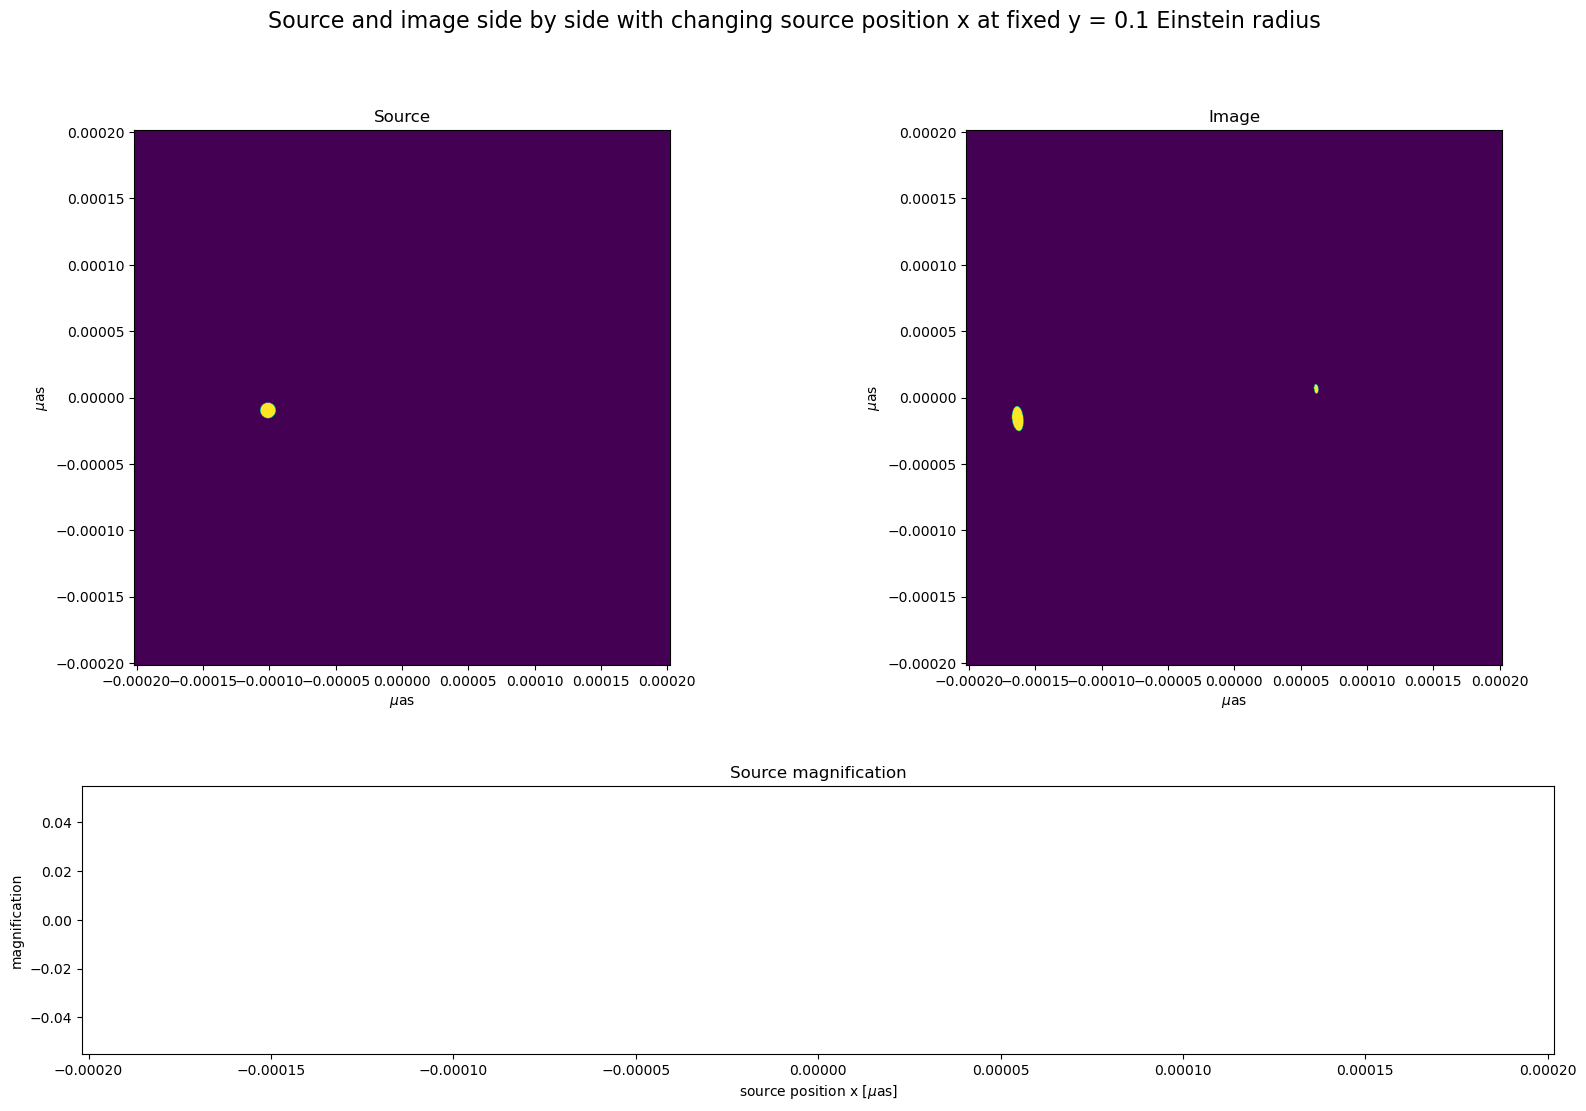

In [53]:
# now we make an animation of the source moving across the lens with some impact parameter
# the animation is rendered here in the notebook with IPython.display.HTML

%matplotlib inline

impact_parameter = 0.1 # in units of the Einstein radius

ani = plot_source_and_image_side_by_side_single_lens_animation(source_pos_x_vals=np.linspace(-1, 1, 100), source_pos_y=impact_parameter)

# HTML(ani.to_html5_video())



In [54]:
ani.save('source_moving_microlensing_single2.gif', 
         writer = 'imagemagick',
         fps=10)

MovieWriter imagemagick unavailable; using Pillow instead.


## Binary lens

In [7]:
# define secondary lens

M1 = 0.01  # secondary mass of the lens
d_01 = 1  # distance of M0 to M1 in units of AU

theta_E1 = einstein_radius(M1, d_l, d_s)
print(theta_E1, 'Einstein radius [arc seconds]')

0.00010090910723578977 Einstein radius [arc seconds]


In [8]:
# map image to source plane
lens_binary = LensModel(lens_model_list=['POINT_MASS', 'POINT_MASS'])
kwargs_lens_binary = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0},
               {'theta_E': theta_E1, 'center_x': 0.0001, 'center_y': 0}]

beta_x, beta_y = lens_binary.ray_shooting(x, y, kwargs=kwargs_lens_binary)
surface_brightness_binary = ligth.surface_brightness(beta_x, beta_y, kwargs_light)

# calculate image magnification as integral of the surface brightness 
# ('amp'=1 is normalized such that intrinsic flux=1)

mag = np.sum(surface_brightness_binary * grid_scale**2)
print(mag, "image magnification")

# turn 1d array into 2d image
image = util.array2image(surface_brightness_binary)


16.211522503340458 image magnification


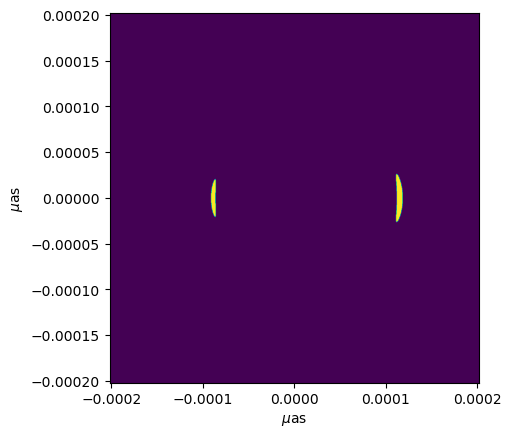

In [30]:
plt.imshow(image, extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
plt.xlabel(r'$\mu$as')
plt.ylabel(r'$\mu$as')
plt.show()

### Animation : Binary Lens

In [59]:
def plot_source_and_image_side_by_side_single_lens_animation(d_l = 4000, 
                                       d_s = 8000, 
                                       M0 = 0.01, 
                                       diameter_s = 1,
                                       source_pos_x_vals = np.linspace(-1, 1, 100),
                                       source_pos_y = 1/4, # fixed
                                       ):
    """
    :param d_l: distance to the lens in pc. Default is 4000 pc
    :param d_s: distance to the source in pc. Default is 8000 pc
    :param M0: mass of the lens in units of M_sol. Default is 0.01 (mass is choosen relatively small such that the numerical ray-tracing is efficient)
    :param diameter_s: diameter of the source in units of the solar radius. Default is 1
    :param source_pos_x: x position of the source in units of einstein radius. Default is 1/4
    :param source_pos_y: y position of the source in units of einstein radius. Default is 0
    :param ax: matplotlib axis instance. Default is None
    """
    # compute lensing properties
    theta_E = einstein_radius(M0, d_l, d_s)
    size_s = source_size(diameter_s, d_s)

    # compute ray-tracing grid
    grid_scale = size_s / 4.  # ten times the source size resolution
    grid_width = theta_E * 6
    num_pix = int(grid_width / grid_scale)
    x, y = util.make_grid(numPix=num_pix, deltapix=grid_scale)

    # define secondary lens
    M1 = 0.01  # secondary mass of the lens
    d_01 = 1  # distance of M0 to M1 in units of AU
    theta_E1 = einstein_radius(M1, d_l, d_s)

    ## lens model
    # map image to source plane
    lens = LensModel(lens_model_list=['POINT_MASS', 'POINT_MASS'])
    kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0},
               {'theta_E': theta_E1, 'center_x': 0.0001, 'center_y': 0}]
    beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

    org_src_imgs = []
    lensed_src_imgs = []
    src_magnifications = []
    for source_pos_x in tqdm(source_pos_x_vals, desc="Generating images"):
        ## source light profile
        # compute surface brightness
        light = LightModel(light_model_list=['ELLIPSOID'])
        kwargs_light = [{'amp': 1, 'radius': size_s/2 * 10, 'e1': 0, 'e2': 0, 'center_x': source_pos_x*theta_E, 'center_y': source_pos_y*theta_E}]

        # turn 1d array into 2d image
        surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
        lensed_src_img = util.array2image(surface_brightness)

        # calculate image magnification as integral of the surface brightness 
        # ('amp'=1 is normalized such that intrinsic flux=1)
        mag = np.sum(surface_brightness * grid_scale**2)
        src_magnifications.append(mag)


        # original source light profile
        org_src_img = light.surface_brightness(x, y, kwargs_light)
        org_src_img = util.array2image(org_src_img)

        org_src_imgs.append(org_src_img)
        lensed_src_imgs.append(lensed_src_img)

    # plot the images side by side and make an animation
    fig = plt.figure(figsize=(19, 12))
    gs = GridSpec(2, 2, height_ratios=[1, 0.5], hspace=0.3, wspace=0.3)

    ax = [fig.add_subplot(gs[0, 0]),  # First row, first column
          fig.add_subplot(gs[0, 1]),  # First row, second column
          fig.add_subplot(gs[1, :])]  # Second row, spanning both columns

    def update(i):
        ax[0].imshow(org_src_imgs[i], extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
        ax[1].imshow(lensed_src_imgs[i], extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
        ax[2].cla()
        ax[2].plot(source_pos_x_vals[:i]*theta_E, src_magnifications[:i])
        ax[2].set_title("Source magnification")
        ax[2].set_xlabel("source position x [$\\mu$as]")
        ax[2].set_ylabel("magnification")
        ax[2].set_xlim(-grid_width/2, grid_width/2)
        ax[2].set_ylim(np.min(src_magnifications)-0.1, np.max(src_magnifications)+0.1)

    ax[0].set_title("Source")
    ax[0].set_xlabel(r'$\mu$as')
    ax[0].set_ylabel(r'$\mu$as')
    ax[1].set_title("Image")
    ax[1].set_xlabel(r'$\mu$as')
    ax[1].set_ylabel(r'$\mu$as')

    fig.suptitle(f"Source and image side by side with changing source position x at fixed y = {source_pos_y} Einstein radius", fontsize=16)

    anim  = animation.FuncAnimation(fig, update, frames=len(source_pos_x_vals), interval=100)

    return anim, src_magnifications, org_src_imgs, lensed_src_imgs

Generating images: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


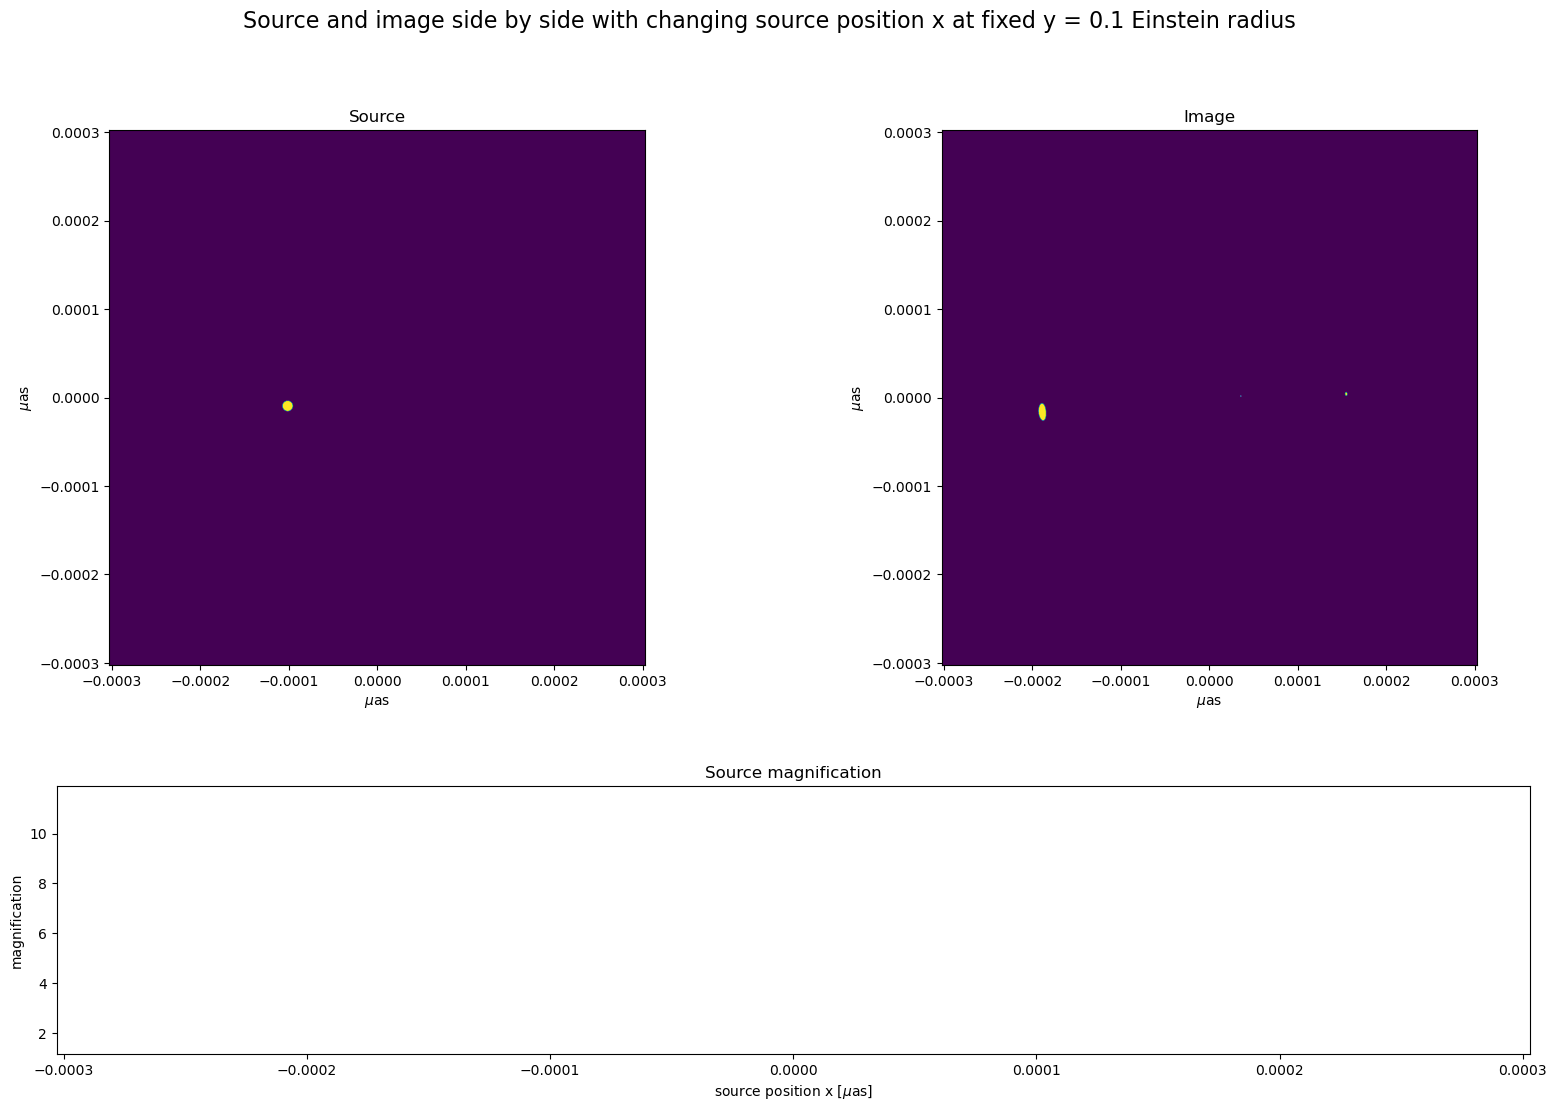

In [60]:
# binary lens animation

impact_parameter = 0.1 # in units of the Einstein radius

ani = plot_source_and_image_side_by_side_single_lens_animation(source_pos_x_vals=np.linspace(-1, 1, 100), source_pos_y=impact_parameter)


Text(0, 0.5, '$\\mu$as')

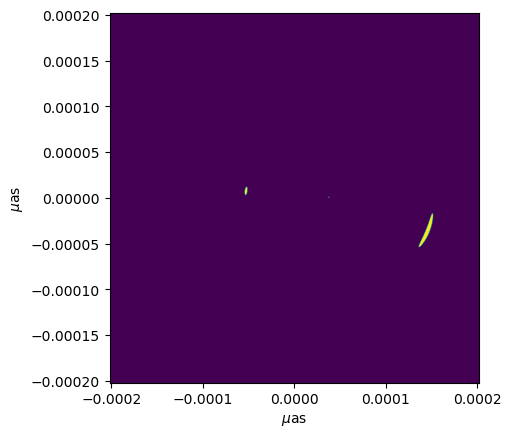

In [62]:
plt.imshow(ani[3][99], extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
plt.xlabel(r'$\mu$as')
plt.ylabel(r'$\mu$as')

In [ ]:
# save the animation as a video file
ani[0].save(
    'source_moving_microlensing_binary.gif',
            writer = 'imagemagick',
            fps=10
            )

MovieWriter imagemagick unavailable; using Pillow instead.


## Quasar Micro-lensing with Lenstronomy

In [88]:
def simulate_multiple_point_lenses(d_l = 4000, 
                                       d_s = 8000, 
                                       M0 = 0.01,
                                       num_lenses = 2, 
                                       diameter_s = 1,
                                       source_pos_x_vals = np.linspace(-2, 2, 100),
                                       source_pos_y = 1/4, # fixed
                                       ):
    """
    :param d_l: distance to the lens in pc. Default is 4000 pc
    :param d_s: distance to the source in pc. Default is 8000 pc
    :param M0: mass of the lens in units of M_sol. Default is 0.01 (mass is choosen relatively small such that the numerical ray-tracing is efficient)
    :param diameter_s: diameter of the source in units of the solar radius. Default is 1
    :param source_pos_x: x position of the source in units of einstein radius. Default is 1/4
    :param source_pos_y: y position of the source in units of einstein radius. Default is 0
    :param ax: matplotlib axis instance. Default is None
    """
    # compute lensing properties
    theta_E = einstein_radius(M0, d_l, d_s)
    size_s = source_size(diameter_s, d_s)

    # compute ray-tracing grid
    grid_scale = size_s / 4.  # ten times the source size resolution
    grid_width = theta_E * 6
    num_pix = int(grid_width / grid_scale)
    x, y = util.make_grid(numPix=num_pix, deltapix=grid_scale)

    ## lens model
    # map image to source plane
    lens = LensModel(lens_model_list=['POINT_MASS']*num_lenses)
    # define the positions of the lenses
    lens_positions_x = np.random.uniform(-0.0005, 0.0005, num_lenses)
    lens_positions_y = np.random.uniform(-0.0005, 0.0005, num_lenses)
    kwargs_lens = [{'theta_E': theta_E, 'center_x': lens_positions_x[i], 'center_y': lens_positions_y[i]} for i in range(num_lenses)]
    beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

    org_src_imgs = []
    lensed_src_imgs = []
    src_magnifications = []
    for source_pos_x in tqdm(source_pos_x_vals, desc="Generating images"):
        ## source light profile
        # compute surface brightness
        light = LightModel(light_model_list=['ELLIPSOID'])
        kwargs_light = [{'amp': 1, 'radius': size_s/2 * 10, 'e1': 0, 'e2': 0, 'center_x': source_pos_x*theta_E, 'center_y': source_pos_y*theta_E}]

        # turn 1d array into 2d image
        surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
        lensed_src_img = util.array2image(surface_brightness)

        # calculate image magnification as integral of the surface brightness 
        # ('amp'=1 is normalized such that intrinsic flux=1)
        mag = np.sum(surface_brightness * grid_scale**2)
        src_magnifications.append(mag)


        # original source light profile
        org_src_img = light.surface_brightness(x, y, kwargs_light)
        org_src_img = util.array2image(org_src_img)

        org_src_imgs.append(org_src_img)
        lensed_src_imgs.append(lensed_src_img)
            
    # plot the images side by side and make an animation
    fig = plt.figure(figsize=(19, 12))
    gs = GridSpec(2, 2, height_ratios=[1, 0.5], hspace=0.3, wspace=0.3)

    ax = [fig.add_subplot(gs[0, 0]),  # First row, first column
          fig.add_subplot(gs[0, 1]),  # First row, second column
          fig.add_subplot(gs[1, :])]  # Second row, spanning both columns

    def update(i):
        ax[0].imshow(org_src_imgs[i], extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
        ax[1].imshow(lensed_src_imgs[i], extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])
        ax[2].cla()
        ax[2].plot(source_pos_x_vals[:i]*theta_E, src_magnifications[:i])
        ax[2].set_title("Source magnification")
        ax[2].set_xlabel("source position x [$\\mu$as]")
        ax[2].set_ylabel("magnification")
        ax[2].set_xlim(-grid_width/2, grid_width/2)
        ax[2].set_ylim(np.min(src_magnifications)-0.1, np.max(src_magnifications)+0.1)

    ax[0].set_title("Source")
    ax[0].set_xlabel(r'$\mu$as')
    ax[0].set_ylabel(r'$\mu$as')
    ax[1].set_title("Image")
    ax[1].set_xlabel(r'$\mu$as')
    ax[1].set_ylabel(r'$\mu$as')

    fig.suptitle(f"Source and image side by side with changing source position x at fixed y = {source_pos_y} Einstein radius", fontsize=16)

    anim  = animation.FuncAnimation(fig, update, frames=len(source_pos_x_vals), interval=100)

    return anim, src_magnifications, org_src_imgs, lensed_src_imgs

Generating images: 100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


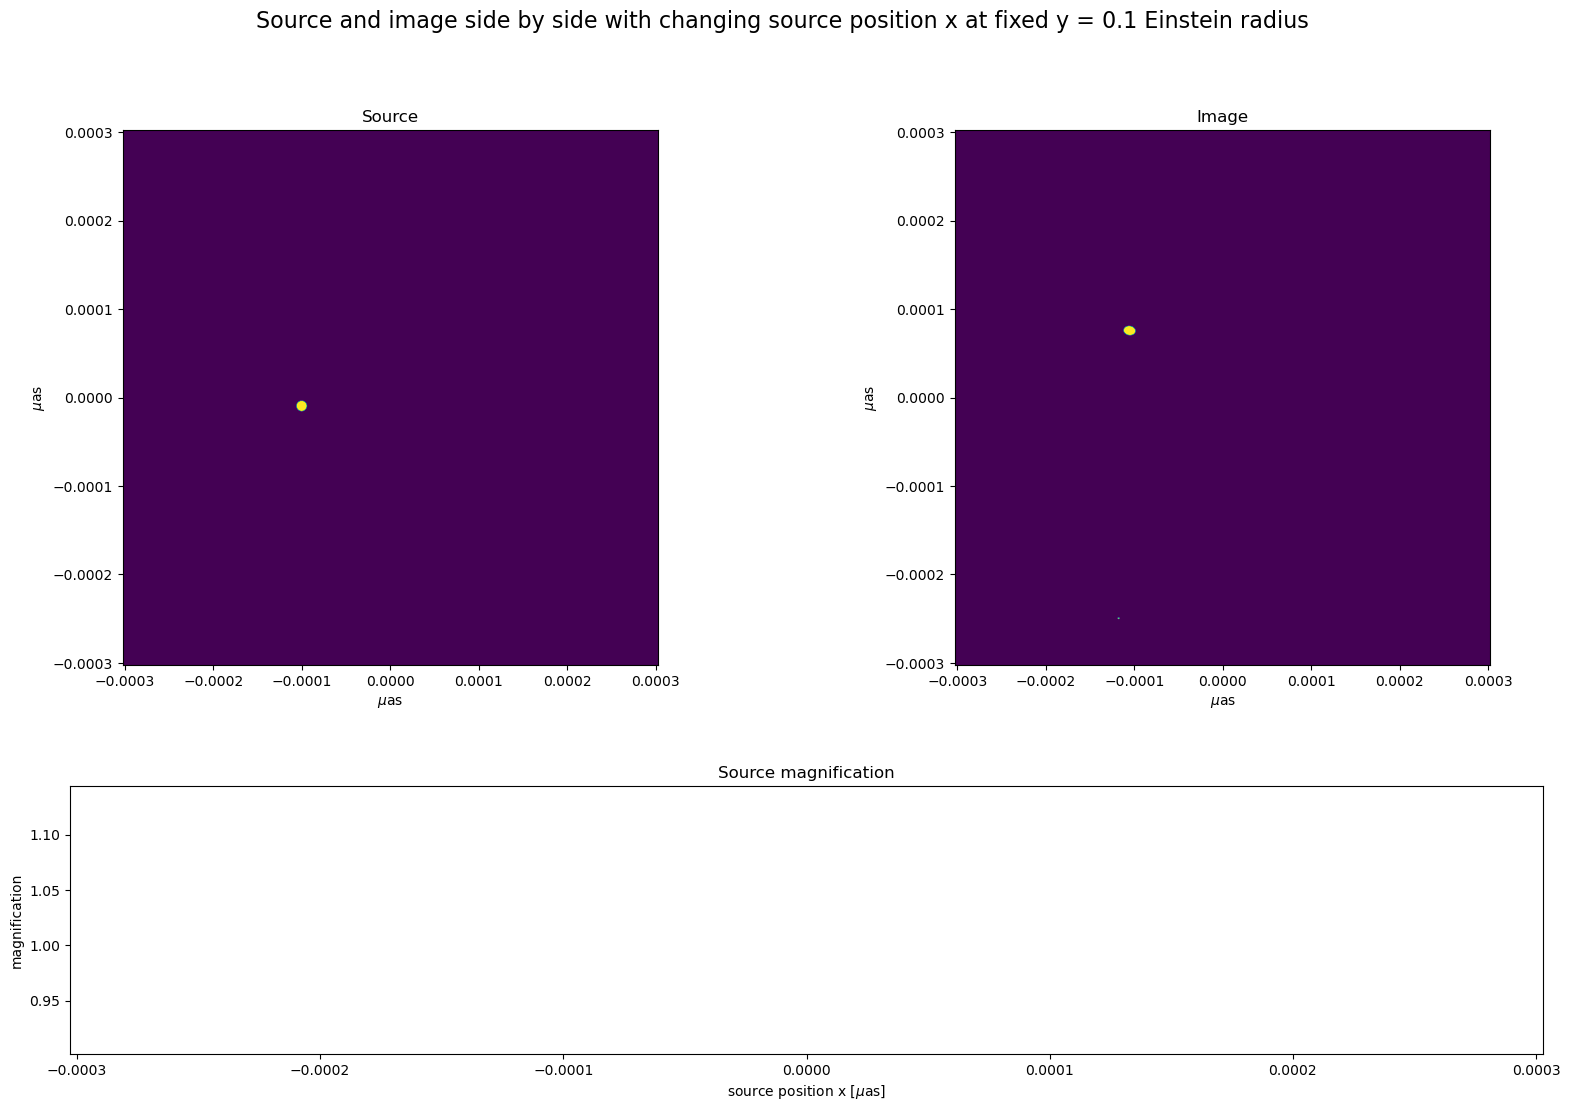

In [104]:
# binary lens animation

impact_parameter = 0.1 # in units of the Einstein radius

ani = simulate_multiple_point_lenses(source_pos_x_vals=np.linspace(-1, 1, 100), source_pos_y=impact_parameter, 
                                     num_lenses=5)


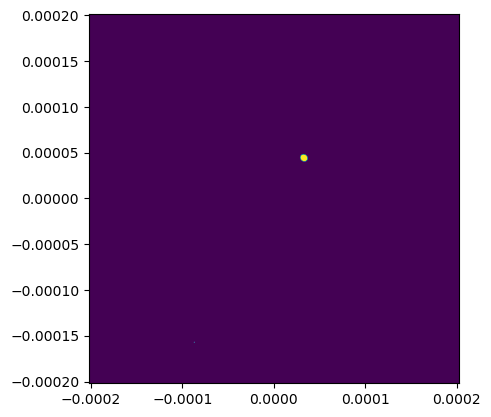

: 

In [ ]:
plt.imshow(ani[3][70], extent = [-grid_width/2, grid_width/2, -grid_width/2, grid_width/2])

In [82]:
# save the animation as a video file
ani[0].save(
    'source_moving_microlensing_50_PLs.gif',
            writer = 'imagemagick',
            fps=10
            )

MovieWriter imagemagick unavailable; using Pillow instead.


KeyboardInterrupt: 